In [112]:
# 24년 12월 7일
# commit 한 사람: 이성은
# 회귀분석 시행
# value와의 관계에서 선형성을 가지는 feature는 없었으나 overroll을 로그 변환 시켜서 수행해봄
# 결정계수 (R^2): 0.8608434467463122

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train = pd.read_csv("FIFA_train.csv")
test = pd.read_csv("FIFA_test.csv")

남은 계약기간으로 변경

In [8]:
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [9]:
train.contract_until = train.contract_until.apply(con_period).astype('float64')
train.contract_until -= 2017

test.contract_until = test.contract_until.apply(con_period).astype('float64')
test.contract_until -= 2017

포지션도 수치형으로 변환

In [14]:
position_mapping = {
    'GK': 1,  # Goalkeeper
    'DF': 2,  # Defender
    'MF': 3,  # Midfielder
    'ST': 4   # Striker
}

train['position'] = train['position'].map(position_mapping)
test['position'] = test['position'].map(position_mapping)

회귀분석을 실행하기 위해 수치형 데이터만 남기기

In [15]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   float64
 5   position          8932 non-null   int64  
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(4), int64(5), object(3)
memory usage: 837.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------ 

In [16]:
# 훈련 데이터에서 필요한 열 선택
X_train = train.drop(columns=['id', 'name', 'continent', 'prefer_foot', 'value'])
y_train = train['value']  # 종속 변수

# 테스트 데이터에서 동일한 열 선택
X_test = test.drop(columns=['id', 'name', 'continent', 'prefer_foot'])

회귀분석을 위한 시각화

In [39]:
def scatter(feature):
    plt.scatter(feature, y_train, alpha=0.7)
    plt.title("Feature vs Target")
    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.show()

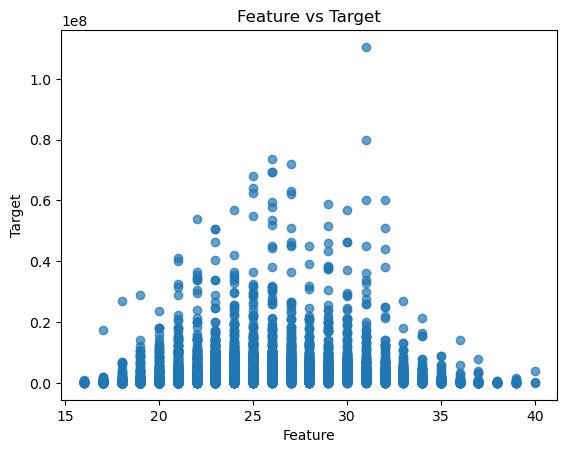

In [44]:
scatter(X_train['age'])

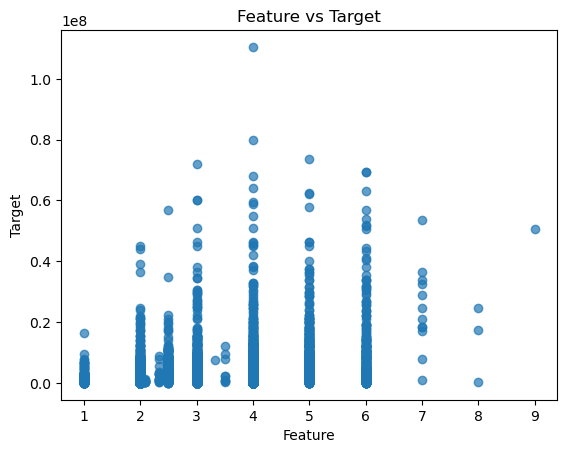

In [48]:
scatter(X_train['contract_until'])

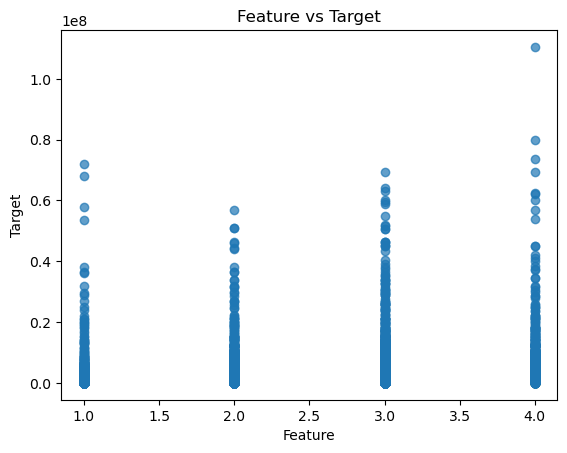

In [49]:
scatter(X_train['position'])

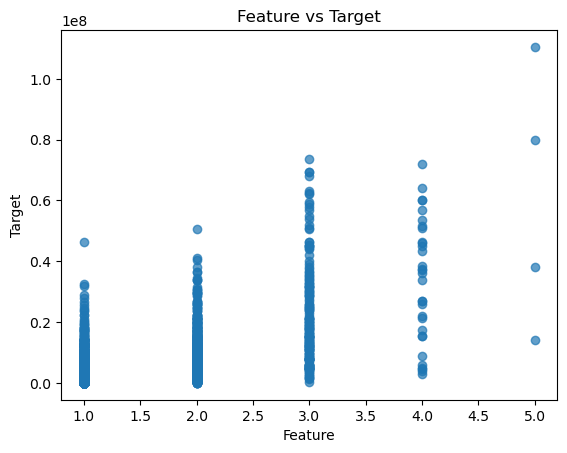

In [50]:
scatter(X_train['reputation'])

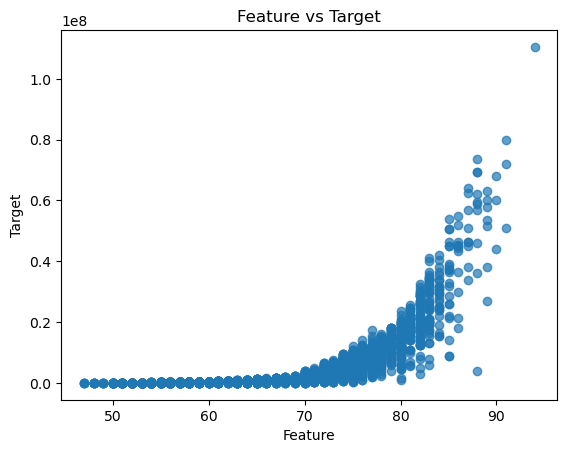

In [51]:
scatter(X_train['stat_overall'])

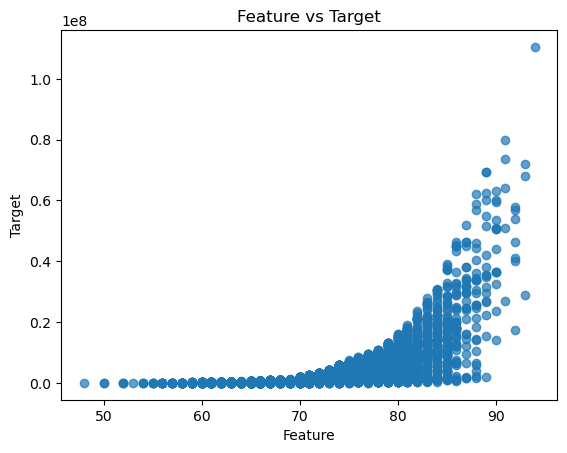

In [52]:
scatter(X_train['stat_potential'])

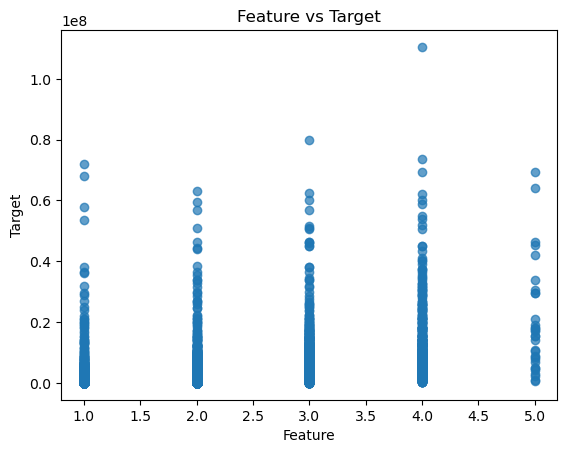

In [53]:
scatter(X_train['stat_skill_moves'])

선형성을 보이는 데이터가 없음 stat_overall을 로그 변환 시도

In [54]:
X_train_log = np.log1p(X_train)  # 독립 변수 로그 변환
y_train_log = np.log1p(y_train)

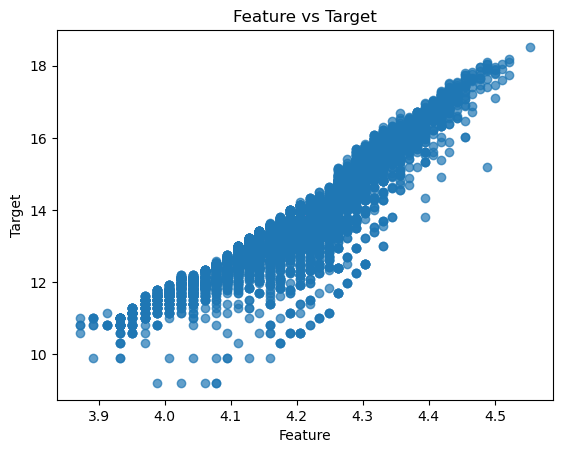

In [56]:
plt.scatter(X_train_log['stat_overall'], y_train_log, alpha=0.7)
plt.title("Feature vs Target")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

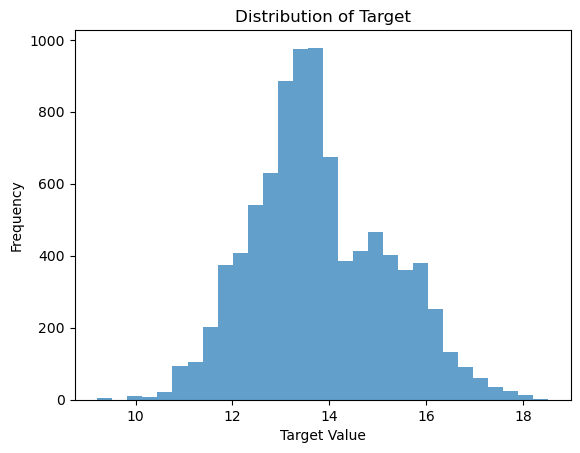

In [58]:
plt.hist(y_train_log, bins=30, alpha=0.7)
plt.title("Distribution of Target")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()

In [63]:
from scipy.stats import shapiro
from scipy.stats import kstest, norm
import statistics

print(shapiro(y_train_log))
print(kstest(y_train_log, "norm", args=(np.mean(y_train_log), np.std(y_train_log))))

ShapiroResult(statistic=0.9879473447799683, pvalue=7.286204358253034e-27)
KstestResult(statistic=0.08050401690628206, pvalue=8.43206092126591e-51, statistic_location=13.815511557963774, statistic_sign=1)


In [64]:
from scipy.stats import anderson
result = anderson(y_train_log, dist="norm")
print("Statistic:", result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

# 결과 해석
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"Significance Level {sl}%: Critical Value {cv}")
if result.statistic > result.critical_values[2]:  # 보통 5% 유의 수준 사용
    print("데이터가 정규분포를 따르지 않습니다.")
else:
    print("데이터가 정규분포를 따릅니다.")

Statistic: 45.744812432694744
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Significance Level 15.0%: Critical Value 0.576
Significance Level 10.0%: Critical Value 0.656
Significance Level 5.0%: Critical Value 0.787
Significance Level 2.5%: Critical Value 0.918
Significance Level 1.0%: Critical Value 1.092
데이터가 정규분포를 따르지 않습니다.


In [65]:
from scipy.stats import kurtosis, skew

kurt = kurtosis(y_train_log)
print(f"첨도(Kurtosis): {kurt:.4f}")

# 왜도
skewness = skew(y_train_log)
print(f"왜도(Skewness): {skewness:.4f}")

첨도(Kurtosis): -0.2001
왜도(Skewness): 0.3087


데이터가 정규분포는 아니지만 왜도가 너무 큰 것은 아닌거 같기에 회귀분석을 실행해볼만하다고 판단

In [75]:
#스탯과 가치와의 로그 변환을 통해 회귀분석 시행

x_train1 = X_train_log['stat_overall']
y_train1 = y_train_log
x_test1 = np.log1p(X_test['stat_overall'])

In [76]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    x_train1, y_train1, test_size=0.2, random_state=42
)

In [92]:
if len(X_val_split.shape) == 1:
    X_val_split = X_val_split.to_numpy().reshape(-1, 1)

In [93]:
# 선형 회귀 모델 생성
model = LinearRegression()

# 학습
model.fit(X_train_split, y_train_split)


LinearRegression()

In [94]:
# 예측
y_pred_val = model.predict(X_val_split)

# 평가 지표
mse = mean_squared_error(y_val_split, y_pred_val)
r2 = r2_score(y_val_split, y_pred_val)

print(f"평균 제곱 오차 (MSE): {mse}")
print(f"결정계수 (R^2): {r2}")

평균 제곱 오차 (MSE): 0.29783857519078616
결정계수 (R^2): 0.8608434467463122


In [104]:
if len(x_test1.shape) == 1:
    x_test1 = x_test1.to_numpy().reshape(-1, 1)
if len(x_train1.shape) == 1:
    x_train1 = x_train1.to_numpy().reshape(-1, 1)

In [105]:
# 모델을 전체 훈련 데이터로 학습
model.fit(x_train1, y_train1)

# 테스트 데이터 예측
y_pred_test = model.predict(x_test1)

In [107]:
np.expm1(y_pred_test)

array([7.38842797e+07, 5.62850716e+07, 4.90182099e+07, ...,
       1.55580460e+04, 1.19520519e+04, 1.19520519e+04])

In [108]:
test['value'] = np.expm1(y_pred_test)

In [109]:
test

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,1,Cristiano Ronaldo,33,europe,5.0,4,right,5.0,94,94,5.0,7.388428e+07
1,2,Neymar Jr,26,south america,5.0,4,right,5.0,92,93,5.0,5.628507e+07
2,4,K. De Bruyne,27,europe,6.0,3,right,4.0,91,92,4.0,4.901821e+07
3,5,E. Hazard,27,europe,3.0,4,right,4.0,91,91,4.0,4.901821e+07
4,6,L. Modrić,32,europe,3.0,3,right,4.0,91,91,4.0,4.901821e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
3823,16924,R. Takae,20,asia,4.0,3,right,1.0,48,63,2.0,1.555805e+04
3824,16929,L. Wahlstedt,18,europe,1.0,1,right,1.0,48,65,1.0,1.555805e+04
3825,16932,Y. Góez,18,south america,4.0,3,right,1.0,48,65,2.0,1.555805e+04
3826,16937,A. Kaltner,18,europe,3.0,4,right,1.0,47,61,2.0,1.195205e+04


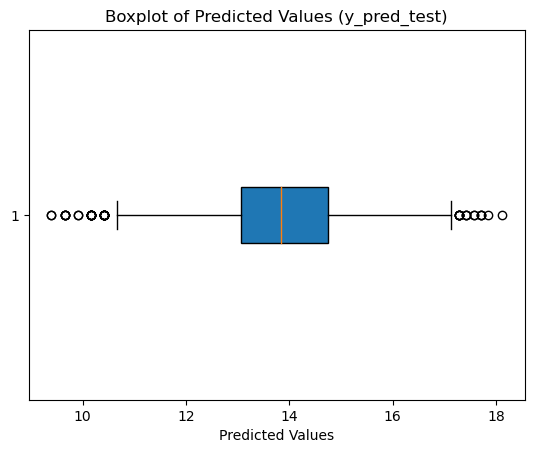

In [110]:
plt.boxplot(y_pred_test, vert=False, patch_artist=True)
plt.title('Boxplot of Predicted Values (y_pred_test)')
plt.xlabel('Predicted Values')
plt.show()